# IMA 205 - TP ANN (part B)

## Coding a Multi-Layer Perceptron with Pytorch

Original Author : Alasdair Newson (https://sites.google.com/site/alasdairnewson/)

Adapted by Loic Le Folgoc. If you have questions, contact me at loic.lefolgoc@telecom-paris.fr

In this part of the lab, we will be looking at the Multi-Layer Perceptron (MLP) using Pytorch (https://pytorch.org/)

We will be using the following packages :
   
   - Scikit-learn (http://scikit-learn.org/)
   - Pytorch (https://pytorch.org/)

### Your task:
You need to add the missing parts in the code (generally marked by `...`)

The following commands will make sure that you have all the necessary packages

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import pdb

import sklearn  # scikit-learn
import torch

# import pytorch modules
import torch.nn as nn
import torch.optim as optim
print(torch.__version__)

from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

2.2.2+cpu


In [2]:
from tqdm import tqdm

# 1 - Multi-Layer Perceptron with Pytorch

We will replay the example in the first part of the lab, but implemented fully in Pytorch.

## Introduction to Pytorch

Pytorch is a library written by Meta which allows easy implementation of deep neural networks. In particular, it provides automatic differentiation so that the user does not have to determine gradients manually, which can be extremely long even for simple networks, as you have seen in the previous part.

This, in turn allows a user to apply techniques such as stochastic gradient descent for training purposes. The differentiation graph is created symbolically when the network is created. Since a neural network is simply a cascade (or concatenation) of simple functions, the network in Pytorch is simply a sequence of functions which are applied to one or several variables. The output of the final function is the output of the network.

For instance, if the input were ```x``` and the network consisted of two functions ```a``` and ```b```, you could create the network simply by writing :

```y = b(a(x))```

However, it is clear that these functions and variables must be of some special type, so that the computer can figure out how to carry out the automatic differentiation for training. Pytorch provides these functions and variables, which must be created with the Pytorch package.


## Creating a network

In Pytorch, to create a network, there are two (main) methods :

### Creating a model using the Sequential API

Pytorch has a simple way of adding layers to create a neural network. This approach is generally convenient for simple models, with not many tweaks. For this, you have to use the following function :
- ```nn.Sequential()```

After this, you can add layers with the function.

- ```model.add_module('module_name',your_module)```

You can then use any type of ```nn.Module``` (for example ```nn.Dense``` or ```nn.ReLU```) functions to specify different layer types. __Note that adding a ```nn.Module``` to your ```nn.Sequential``` requires you to specify a name for your module. You have to specify different names for each layer. Otherwise, your layers will be overwritten.__ So, for example, if you want a network with one layer as dense layer with a relu activation, with n_out output neurons, and n_in neurons :

- `model = nn.Sequential()`
- `model.add_module('linear1',nn.Linear(n_in,n_out))`
- `model.add_module('relu1',nn.ReLU())`

<br>Otherwise, you can also write the following code that is equivalent to the above using arguments to `nn.Sequential`: `nn.Sequential(nn.Linear(n_in,n_out), nn.ReLU())`.

### Creating a model using the standard API

Otherwise, another approach (allowing more flexibility) to creating the model is to create a subclass of ```nn.Module```. Then, you can define all the necessary layers and hyper-parameters in your ```init``` function and make the forward process you want in the ```forward``` function. So, for the same example, we would have :

- class Model(nn.Module):
  - def __init__(self):
      - super().__init__()
      - self.l1 = nn.Linear(n_in,n_out)
      - self.r1 = nn.ReLU()

  - def forward(self, x):
       - x = self.l1(x)
       - x = self.r1(x)
       - return x

We will implement both the Sequential and standard API.

 __Note:__ You can also combine the two approaches by defining some ```nn.Sequential``` in your class ```init``` and applying them in the ```forward``` function.

## Training and testing a network

Pytorch allows the easy training of a network with the following objects and functions :

- Optimizers: Optimizers (for example `optim.Adam()` or `optim.SGD()`) needs you to give them ```model.parameters``` as argument to let them know which weights have to be optimized. For example: `my_optimizer = optim.Adam(model.parameters())`

- Losses: They can be predefined functions from Pytorch library or arbitrary functions defined by yourself, as long as they are differentiable. For example: `loss_function = nn.BCELoss()` corresponds to the binary cross entropy loss, useful for binary classification.

- `outputs = model(...)` : carry out a simple forward pass on the model and returns the outputs

- `loss_value = loss_function(outputs,ground_truth)` : computes the loss between outputs and ground_truth

- `optimizer.zero_grad()` : Sets all gradients stored in the previous steps to zero. If you don't call this function before a gradient computation, your gradients will added (cumulatively) to the previous ones.

- `loss_value.backward()` : carry out the backpropagation of gradients, populating the `node.grad` fields

- `optimizer.step()`: apply the parameter update to the trainable parameters controlled by the optimizer, according to the specific class of `optimizer`

# Loading and formatting the data

First, we load the data from sklearn. We create train and test splits.

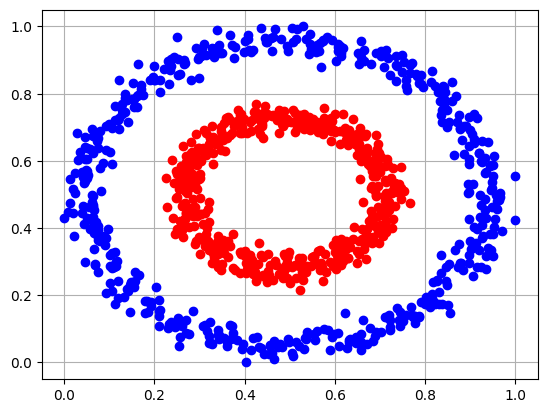

In [3]:
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Create data
X, Y = datasets.make_circles(n_samples=1000, noise=0.05, factor=0.5)
# X, Y = datasets.make_moons(n_samples=1000, random_state=42)  # try with 2 moons


# Normalize the data. If we were doing things by the textbook, we would need to fit the
# MinMaxScaler on the training data X_train only, then apply it to both training and
# test data X_train and X_test:
X = MinMaxScaler().fit_transform(X)

# Show data in plot
plt.plot(X[Y == 1, 0], X[Y == 1, 1], 'ro')
plt.plot(X[Y == 0, 0], X[Y == 0, 1], 'bo')
plt.grid('on')

In [4]:
# We split up the data into training and test data, using a function from
# Scikit-learn :
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)
print('Training set shape: {}'.format(X_train.shape))
print('Test set shape: {}'.format(X_test.shape))

Training set shape: (850, 2)
Test set shape: (150, 2)


Finally, we need to create `torch.utils.data.Dataset` objects from these numpy datasets. These datasets are Pytorch objects, which typically implement a `get_item(i)` method which manages the retrieval of the i-th item in the dataset, and return it as a torch `Tensor` object (or tuple thereof).

A useful subclass for us is `TensorDataset`, which does the magic under the hood for us for this simple case where we have data points and labels already available:

In [5]:
training_dataset  = TensorDataset(torch.tensor(X_train).float(), # Creates a pytorch Dataset object
                                  torch.unsqueeze(torch.tensor(Y_train),-1).float()) 
test_dataset  = TensorDataset(torch.tensor(X_test).float(),      # Creates a pytorch Dataset object
                              torch.unsqueeze(torch.tensor(Y_test),-1).float()) 

# Device

We will use the GPU if it is available on your machine, otherwise the CPU. We do so by putting the model and data on the active device with `.to(device)`. GPU training is 6-10x faster here.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Creating the MLP with Pytorch : Architecture

We are now going to create an MLP with pytorch. We will start with an MLP with one hidden layer, similar to part 1 of the lab. The network should consist of the following operations, in the following order :

- Fully connected layer (with biases), mapping the input data (2D) to `n_hidden` neurons, using `nn.Linear(...)`
- ReLU activation, using `nn.ReLu()`
- Fully connected layer (with biases), mapping the hidden layer to the output layer with 1 neuron
- Sigmoid output activation, using `nn.Sigmoid()`

We are going to be solving a binary classification problem, so the output of the network should be a scalar between 0 and 1 (thus the last Sigmoid activation function).

In [7]:
# Parameters:
n_input = 2
n_hidden = 50
n_output = 1

In [8]:
# TO COMPLETE:

class MLP(nn.Module):

  def __init__(self, n_input, n_hidden, n_output):
    super().__init__()

    # We can only define the linear/dense layers here, and call the functional versions
    # of ReLu and Sigmoid, F.relu() and torch.sigmoid(), directly in the forward
    self.linear1 = nn.Linear(n_input, n_hidden)
    self.linear2 = nn.Linear(n_hidden, n_output)

  def forward(self, x):
    # Code the chain of operations to produce the output y from x
    x = F.relu(self.linear1(x))
    x = torch.sigmoid(self.linear2(x))
    
    return x

Implement, train and test both the sequential and standard APIs below (switch sequential to `False` and run the code blocks below to test the standard API):

In [9]:
sequential = True

if sequential:
  # Sequential API:
  model = nn.Sequential(MLP(n_input, n_hidden, n_output))
  sequential = False
else:
  # Standard API
  model = MLP(n_input, n_hidden, n_output)

In [10]:
model = model.to(device)

# Training the model

We are now going to train the model itself. First, we need to define model parameters (batch size, number of epochs, etc.). Then we will define the loss, the optimizer and start the training.

In [11]:
learning_rate = 0.01
n_epochs = 30
batch_size = 64

We will use the binary cross entropy loss from Pytorch. For now, we instantiate an `nn.BCELoss()` object. We will call it during the training on specific outputs $\hat{y}$ and ground truth values $y$.

Use the argument `reduction='sum'` for compatibility with my code below (it corresponds to one of several possible ways to aggregate the individual losses from individual data points).

In [12]:
criterion = nn.BCELoss(reduction='sum')

We now define the optimizer. We use the Adam optimizer from `optim.Adam`, passing `model.parameters()` as trainable parameters and setting the learning rate to `learning_rate`:

In [13]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Finally, we need to define a `DataLoader`. It takes as input the torch dataset, the batch size, and a number of optional arguments. The dataloader is responsible for creating minibatches for the training (and/or for the inference/test-time).

It is a highly customizable process that relies on a `sampler`. The default sampler (when you do not specify a particular sampler) just samples data points uniformly at random from the full batch to create the minibatch. This default behaviour is very often good enough. We do not worry about this for today and rely on this default behaviour.

In [14]:
training_loader = DataLoader(training_dataset, batch_size =  batch_size, shuffle = True, drop_last = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, drop_last = False)

We can now move on to the main training loop. It iterates over the dataset for a number of epochs. Each epoch involves a number of iterations: at each iteration, a minibatch is processed and the iteration culminates in a parameter update.

In [15]:
# Helper function: we monitor the accuracy during the training
def prediction_accuracy(predict,labels):
  accuracy = (predict == labels).sum()/(labels.shape[0])
  return accuracy

In [16]:
model.train()

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  with tqdm(training_loader, unit="batch") as tepoch:
    for data, labels in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put the data on device
      data = data.to(device)
      labels = labels.to(device)

      # BEGIN STUDENT CODE: forward and backward passes

      # 1. Do the forward pass
      y_predict = model(data)

      # 2. Compute the loss
      loss = criterion(y_predict, labels)

      # 3. Reset gradients to 0
      optimizer.zero_grad()

      # 4. Do the backward pass
      loss.backward()

      # 5. Call the parameter update
      optimizer.step()

      # END STUDENT CODE

      # Compute the loss
      train_loss += loss.item()
      # Store labels and class predictions
      all_labels.extend(labels.tolist())
      all_predicted.extend((y_predict>=0.5).tolist())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(training_loader.dataset)))
  print('Epoch {}: Train Accuracy: {:.4f}'.format(epoch, prediction_accuracy(np.array(all_predicted),
                                                                             np.array(all_labels))))

Epoch 0: 100%|██████████| 14/14 [00:00<00:00, 163.39batch/s]


Epoch 0: Train Loss: 0.6881
Epoch 0: Train Accuracy: 0.5518


Epoch 1: 100%|██████████| 14/14 [00:00<00:00, 151.60batch/s]


Epoch 1: Train Loss: 0.6740
Epoch 1: Train Accuracy: 0.5965


Epoch 2: 100%|██████████| 14/14 [00:00<00:00, 144.44batch/s]


Epoch 2: Train Loss: 0.6478
Epoch 2: Train Accuracy: 0.8682


Epoch 3: 100%|██████████| 14/14 [00:00<00:00, 131.37batch/s]


Epoch 3: Train Loss: 0.6242
Epoch 3: Train Accuracy: 0.7894


Epoch 4: 100%|██████████| 14/14 [00:00<00:00, 153.84batch/s]


Epoch 4: Train Loss: 0.5956
Epoch 4: Train Accuracy: 0.8965


Epoch 5: 100%|██████████| 14/14 [00:00<00:00, 162.41batch/s]


Epoch 5: Train Loss: 0.5628
Epoch 5: Train Accuracy: 0.9588


Epoch 6: 100%|██████████| 14/14 [00:00<00:00, 164.27batch/s]


Epoch 6: Train Loss: 0.5218
Epoch 6: Train Accuracy: 0.9941


Epoch 7: 100%|██████████| 14/14 [00:00<00:00, 144.26batch/s]


Epoch 7: Train Loss: 0.4835
Epoch 7: Train Accuracy: 0.9847


Epoch 8: 100%|██████████| 14/14 [00:00<00:00, 111.31batch/s]


Epoch 8: Train Loss: 0.4402
Epoch 8: Train Accuracy: 0.9824


Epoch 9: 100%|██████████| 14/14 [00:00<00:00, 134.34batch/s]


Epoch 9: Train Loss: 0.3998
Epoch 9: Train Accuracy: 0.9988


Epoch 10: 100%|██████████| 14/14 [00:00<00:00, 126.95batch/s]


Epoch 10: Train Loss: 0.3621
Epoch 10: Train Accuracy: 0.9941


Epoch 11: 100%|██████████| 14/14 [00:00<00:00, 124.50batch/s]


Epoch 11: Train Loss: 0.3204
Epoch 11: Train Accuracy: 0.9965


Epoch 12: 100%|██████████| 14/14 [00:00<00:00, 122.69batch/s]


Epoch 12: Train Loss: 0.2861
Epoch 12: Train Accuracy: 0.9976


Epoch 13: 100%|██████████| 14/14 [00:00<00:00, 166.21batch/s]


Epoch 13: Train Loss: 0.2518
Epoch 13: Train Accuracy: 1.0000


Epoch 14: 100%|██████████| 14/14 [00:00<00:00, 153.23batch/s]


Epoch 14: Train Loss: 0.2253
Epoch 14: Train Accuracy: 0.9988


Epoch 15: 100%|██████████| 14/14 [00:00<00:00, 161.64batch/s]


Epoch 15: Train Loss: 0.2027
Epoch 15: Train Accuracy: 0.9988


Epoch 16: 100%|██████████| 14/14 [00:00<00:00, 154.61batch/s]


Epoch 16: Train Loss: 0.1775
Epoch 16: Train Accuracy: 1.0000


Epoch 17: 100%|██████████| 14/14 [00:00<00:00, 163.77batch/s]


Epoch 17: Train Loss: 0.1599
Epoch 17: Train Accuracy: 1.0000


Epoch 18: 100%|██████████| 14/14 [00:00<00:00, 174.63batch/s]


Epoch 18: Train Loss: 0.1436
Epoch 18: Train Accuracy: 1.0000


Epoch 19: 100%|██████████| 14/14 [00:00<00:00, 155.23batch/s]


Epoch 19: Train Loss: 0.1265
Epoch 19: Train Accuracy: 1.0000


Epoch 20: 100%|██████████| 14/14 [00:00<00:00, 164.07batch/s]


Epoch 20: Train Loss: 0.1136
Epoch 20: Train Accuracy: 1.0000


Epoch 21: 100%|██████████| 14/14 [00:00<00:00, 173.97batch/s]


Epoch 21: Train Loss: 0.1030
Epoch 21: Train Accuracy: 1.0000


Epoch 22: 100%|██████████| 14/14 [00:00<00:00, 174.53batch/s]


Epoch 22: Train Loss: 0.0940
Epoch 22: Train Accuracy: 1.0000


Epoch 23: 100%|██████████| 14/14 [00:00<00:00, 75.85batch/s]


Epoch 23: Train Loss: 0.0852
Epoch 23: Train Accuracy: 1.0000


Epoch 24: 100%|██████████| 14/14 [00:00<00:00, 164.04batch/s]


Epoch 24: Train Loss: 0.0776
Epoch 24: Train Accuracy: 1.0000


Epoch 25: 100%|██████████| 14/14 [00:00<00:00, 154.71batch/s]


Epoch 25: Train Loss: 0.0718
Epoch 25: Train Accuracy: 1.0000


Epoch 26: 100%|██████████| 14/14 [00:00<00:00, 163.58batch/s]


Epoch 26: Train Loss: 0.0660
Epoch 26: Train Accuracy: 1.0000


Epoch 27: 100%|██████████| 14/14 [00:00<00:00, 174.27batch/s]


Epoch 27: Train Loss: 0.0622
Epoch 27: Train Accuracy: 1.0000


Epoch 28: 100%|██████████| 14/14 [00:00<00:00, 169.19batch/s]


Epoch 28: Train Loss: 0.0568
Epoch 28: Train Accuracy: 1.0000


Epoch 29: 100%|██████████| 14/14 [00:00<00:00, 187.94batch/s]

Epoch 29: Train Loss: 0.0526
Epoch 29: Train Accuracy: 1.0000


# Testing the model

Let us now visualize the decision function and compute the test accuracy for the model.

In [17]:
model.eval()

all_predicted = []
all_labels = []

with tqdm(test_loader, unit="batch") as tepoch:
  for data, labels in tepoch:
    all_labels.extend(labels.tolist())

    data = data.to(device)
    y_predict = model(data)
    all_predicted.extend((y_predict>=0.5).tolist())

test_accuracy = prediction_accuracy(np.array(all_predicted),np.array(all_labels))

print("\nTest Accuracy:", test_accuracy)

100%|██████████| 3/3 [00:00<?, ?batch/s]


Test Accuracy: 1.0


Here is a function that shows the decision boundary of our network. This works only for 2D input data:

In [18]:
# THIS CODE IS GIVEN:

def plot_decision_function_2d(model, X, Y):
   # create a mesh to plot in
    h = .02  # step size in the mesh
    offset = 0.1
    x_min, x_max = X[:, 0].min() - offset, X[:, 0].max() + offset
    y_min, y_max = X[:, 1].min() - offset, X[:, 1].max() + offset
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float().to(device)).detach().cpu().numpy()
    Z = Z<0.5

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

    plt.plot(X[Y == 1, 0], X[Y == 1, 1], 'yo')
    plt.plot(X[Y == 0, 0], X[Y == 0, 1], 'ko')

    plt.title("Decision surface")
    plt.axis('tight')

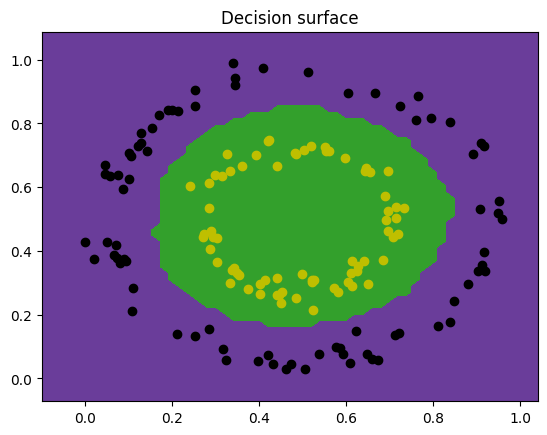

In [19]:
plot_decision_function_2d(model, X_test, Y_test)

# 2 - MLP with several hidden layers, on MNIST

We are now going to create an MLP with several hidden layers. We are going to use a more complicated dataset : the MNIST dataset, which contains images of handwritten digits. There are 10 classes, one for each digit.

We are going to implement the following architecture :

- Fully connected layer, mapping from `n_input` to `n_hidden_1` neurons
- Relu activation
- Fully connected layer, mapping from `n_hidden_1` to `n_hidden_2` neurons
- Relu activation
- Fully connected layer, mapping from `n_hidden_2` to `n_hidden_3` neurons
- Relu activation
- Fully connected layer, mapping from `n_hidden_3` to `n_output` (=10) neurons

__IMPORTANT Note__ The sigmoid layer has been removed. Ideally, we should have replaced it by a softmax layer (at the end) since we have a multi-class problem. However, this softmax activation is already present in the loss ```nn.CrossEntropyLoss()```. This is why we don't have to put one here. The unnormalized outputs before this softmax are called logits. Hence, the network outputs logits.

First, we load the MNIST dataset.

In [20]:
# Import MNIST data
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5]),
     lambda x: torch.flatten(x),
     lambda x: x.float()]) # flatten the last two dimensions of the images

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Note that here, we have defined transforms and passed them as argument when creating the dataset. These transforms will be called systematically in the `get_item` method implemented in the dataset, modifying each image before returning it. Here we use this tool to format and normalize input images.

The same process could be used to apply random augmentations to the input images (for data augmentations), by composing with functions that apply random transforms.

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


MLP architecture, via sequential API:

In [22]:
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_hidden_3 = 128 # 3rd layer number of neurons

n_input = trainset[0][0].shape[0] # input shape (a vectorized 28*28 image)
n_output = 10 # MNIST total classes (0-9 digits)

In [23]:
model_multi_layer = nn.Sequential(
    nn.Linear(n_input, n_hidden_1),
    nn.ReLU(),
    nn.Linear(n_hidden_1, n_hidden_2),
    nn.ReLU(),
    nn.Linear(n_hidden_2, n_hidden_3),
    nn.ReLU(),
    nn.Linear(n_hidden_3, n_output)
)

In [24]:
model_multi_layer = model_multi_layer.to(device)

Let us move on to the training. You need to define the loss using the instructions above, and the optimizer as usual. For the loss, use the argument `reduction='sum'` as before for compatibility with my code.

In [25]:
learning_rate = 0.01
n_epochs = 20
batch_size = 64

In [26]:
criterion = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = optim.Adam(model_multi_layer.parameters(), lr = learning_rate)

In [27]:
training_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True, drop_last = False)
test_loader = DataLoader(testset, batch_size = batch_size, shuffle = False, drop_last = False)

Now comes the main loop for the training and testing:

In [28]:
# Helper function: we monitor the accuracy during the training
def vector_to_class(x):
  y = torch.argmax(F.softmax(x,dim=1),axis=1)
  return y

def prediction_accuracy(predict,labels):
  accuracy = (predict == labels).sum()/(labels.shape[0])
  return accuracy

In [29]:
model_multi_layer.train()

for epoch in range(0,n_epochs):
  train_loss=0.0
  all_labels = []
  all_predicted = []

  with tqdm(training_loader, unit="batch") as tepoch:
    for data, labels in tepoch:
      tepoch.set_description(f"Epoch {epoch}")

      # Put the data on device
      data = data.to(device)
      labels = labels.to(device)

      # BEGIN STUDENT CODE: 
      # forward and backward passes

      # 1. Do the forward pass
      y_predict = model_multi_layer(data)

      # 2. Compute the loss
      loss = criterion(y_predict, labels)

      # 3. Reset gradients to 0
      optimizer.zero_grad()

      # 4. Do the backward pass
      loss.backward()

      # 5. Call the parameter update
      optimizer.step()
      
      # END STUDENT CODE

      # Compute the loss
      train_loss += loss.item()

      # Store labels and class predictions
      all_labels.extend(labels.tolist())
      all_predicted.extend(vector_to_class(y_predict).tolist())

  print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(training_loader.dataset)))
  print('Epoch {}: Train Accuracy: {:.4f}'.format(epoch, prediction_accuracy(np.array(all_predicted),
                                                                             np.array(all_labels))))

Epoch 0: 100%|██████████| 938/938 [00:44<00:00, 21.31batch/s]


Epoch 0: Train Loss: 0.4229
Epoch 0: Train Accuracy: 0.8712


Epoch 1: 100%|██████████| 938/938 [00:45<00:00, 20.40batch/s]


Epoch 1: Train Loss: 0.2869
Epoch 1: Train Accuracy: 0.9188


Epoch 2: 100%|██████████| 938/938 [00:43<00:00, 21.35batch/s]


Epoch 2: Train Loss: 0.2552
Epoch 2: Train Accuracy: 0.9295


Epoch 3: 100%|██████████| 938/938 [00:45<00:00, 20.77batch/s]


Epoch 3: Train Loss: 0.2540
Epoch 3: Train Accuracy: 0.9307


Epoch 4: 100%|██████████| 938/938 [00:45<00:00, 20.65batch/s]


Epoch 4: Train Loss: 0.2407
Epoch 4: Train Accuracy: 0.9358


Epoch 5: 100%|██████████| 938/938 [00:44<00:00, 21.13batch/s]


Epoch 5: Train Loss: 0.2339
Epoch 5: Train Accuracy: 0.9390


Epoch 6: 100%|██████████| 938/938 [00:43<00:00, 21.55batch/s]


Epoch 6: Train Loss: 0.2191
Epoch 6: Train Accuracy: 0.9424


Epoch 7: 100%|██████████| 938/938 [00:45<00:00, 20.70batch/s]


Epoch 7: Train Loss: 0.2242
Epoch 7: Train Accuracy: 0.9419


Epoch 8: 100%|██████████| 938/938 [00:46<00:00, 20.22batch/s]


Epoch 8: Train Loss: 0.2077
Epoch 8: Train Accuracy: 0.9467


Epoch 9: 100%|██████████| 938/938 [00:45<00:00, 20.47batch/s]


Epoch 9: Train Loss: 0.2030
Epoch 9: Train Accuracy: 0.9495


Epoch 10: 100%|██████████| 938/938 [00:43<00:00, 21.59batch/s]


Epoch 10: Train Loss: 0.2050
Epoch 10: Train Accuracy: 0.9479


Epoch 11: 100%|██████████| 938/938 [00:44<00:00, 20.97batch/s]


Epoch 11: Train Loss: 0.1991
Epoch 11: Train Accuracy: 0.9497


Epoch 12: 100%|██████████| 938/938 [00:44<00:00, 20.91batch/s]


Epoch 12: Train Loss: 0.1875
Epoch 12: Train Accuracy: 0.9532


Epoch 13: 100%|██████████| 938/938 [00:43<00:00, 21.42batch/s]


Epoch 13: Train Loss: 0.1935
Epoch 13: Train Accuracy: 0.9518


Epoch 14: 100%|██████████| 938/938 [00:49<00:00, 19.01batch/s]


Epoch 14: Train Loss: 0.1928
Epoch 14: Train Accuracy: 0.9520


Epoch 15: 100%|██████████| 938/938 [00:50<00:00, 18.64batch/s]


Epoch 15: Train Loss: 0.1827
Epoch 15: Train Accuracy: 0.9561


Epoch 16: 100%|██████████| 938/938 [00:51<00:00, 18.29batch/s]


Epoch 16: Train Loss: 0.1929
Epoch 16: Train Accuracy: 0.9527


Epoch 17: 100%|██████████| 938/938 [00:50<00:00, 18.68batch/s]


Epoch 17: Train Loss: 0.1856
Epoch 17: Train Accuracy: 0.9539


Epoch 18: 100%|██████████| 938/938 [00:45<00:00, 20.50batch/s]


Epoch 18: Train Loss: 0.1961
Epoch 18: Train Accuracy: 0.9518


Epoch 19: 100%|██████████| 938/938 [00:43<00:00, 21.70batch/s]


Epoch 19: Train Loss: 0.1947
Epoch 19: Train Accuracy: 0.9522


Testing:

In [30]:
model_multi_layer.eval()

all_predicted = []
all_labels = []

with tqdm(test_loader, unit="batch") as tepoch:
  for data, labels in tepoch:
    all_labels.extend(labels.tolist())

    data = data.to(device)
    y_predict = model_multi_layer(data)
    all_predicted.extend(vector_to_class(y_predict).tolist())

test_accuracy = prediction_accuracy(np.array(all_predicted),np.array(all_labels))

print("\nTest Accuracy:", test_accuracy)

100%|██████████| 157/157 [00:03<00:00, 47.61batch/s]


Test Accuracy: 0.9556


We visualize a few images along with the predicted label on top:

In [31]:
def test_mnist_images(model,testset):
  model.eval()
  plt.figure(figsize=(10, 6))
  for idx in range(0,10):
      plt.subplot(2, 5, idx+1)
      rand_ind = np.random.randint(0,len(testset))
      plt.imshow(np.reshape(testset[rand_ind][0].detach().cpu().numpy(),(28,28)),cmap='gray')
      # get prediction
      model_prediction = np.argmax(model(torch.unsqueeze(testset[rand_ind][0], dim=0).to(device)).detach().cpu().numpy(),axis=1).squeeze()
      plt.title(str(int(model_prediction)))

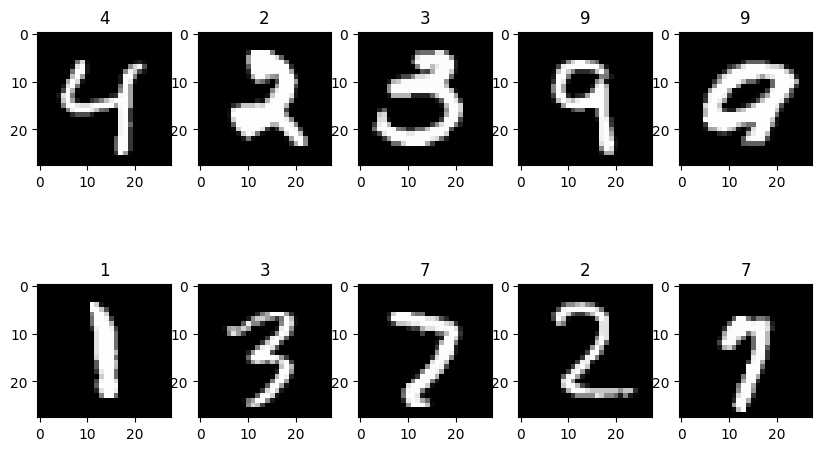

In [32]:
test_mnist_images(model_multi_layer, testset)

The generalization is reasonably good on this simple dataset (on my run). Regardless, to improve training and limit overfitting, we can turn to __regularisation__.

# Batch normalization

One approach to regularisation which we have seen during the lesson is known as batch normalisation. This can be implemented very simply in Tensorflow by adding the following layer :

- ```BatchNorm1d(n_features)```

with `n_features` the number of neurons in the layer immediately prior to the batch norm layer. Change your model below, by adapting the model above. You will put `BatchNorm1d` layers after every ReLu non-linearity.

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


MLP architecture, via sequential API:

In [34]:
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_hidden_3 = 128 # 3rd layer number of neurons

n_input = trainset[0][0].shape[0] # input shape (a vectorized 28*28 image)
n_output = 10 # MNIST total classes (0-9 digits)

In [35]:
model_multi_layer_bn = nn.Sequential(
    nn.Linear(n_input, n_hidden_1),
    nn.BatchNorm1d(n_hidden_1),
    nn.ReLU(),
    nn.Linear(n_hidden_1, n_hidden_2),
    nn.BatchNorm1d(n_hidden_2),
    nn.ReLU(),
    nn.Linear(n_hidden_2, n_hidden_3),
    nn.BatchNorm1d(n_hidden_3),
    nn.ReLU(),
    nn.Linear(n_hidden_3, n_output)
)

In [36]:
model_multi_layer_bn = model_multi_layer_bn.to(device)

Let us move on to the training. You need to define the loss using the instructions above, and the optimizer as usual. For the loss, use the argument `reduction='sum'` as before for compatibility with my code.

In [37]:
learning_rate = 0.01
n_epochs = 20
batch_size = 64

In [38]:
criterion = nn.CrossEntropyLoss(reduction = 'sum')

# Do not forget to change the name of the model if you copy paste code!!!
optimizer = optim.Adam(model_multi_layer_bn.parameters(), lr = learning_rate)

In [39]:
training_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True, drop_last = False)
test_loader = DataLoader(testset, batch_size = batch_size, shuffle = False, drop_last = False)

Now comes the main loop for the training and testing:

In [40]:
# Helper function: we monitor the accuracy during the training
def vector_to_class(x):
  y = torch.argmax(F.softmax(x,dim=1),axis=1)
  return y

def prediction_accuracy(predict,labels):
  accuracy = (predict == labels).sum()/(labels.shape[0])
  return accuracy

In [42]:
# !!! Do not forget to change the name of the model if you copy-paste code !!!

# TRAINING TO COMPLETE BY STUDENTS
model_multi_layer_bn.train()

for epoch in range(0,n_epochs):
    train_loss=0.0
    all_labels = []
    all_predicted = []
    
    with tqdm(training_loader, unit="batch") as tepoch:
        for data, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
        
            # Put the data on device
            data = data.to(device)
            labels = labels.to(device)
        
            # BEGIN STUDENT CODE: forward and backward passes
        
            # 1. Do the forward pass
            y_predict = model_multi_layer_bn(data)
        
            # 2. Compute the loss
            loss = criterion(y_predict, labels)
        
            # 3. Reset gradients to 0
            optimizer.zero_grad()
        
            # 4. Do the backward pass
            loss.backward()
        
            # 5. Call the parameter update
            optimizer.step()
        
            # END STUDENT CODE
        
            # Compute the loss
            train_loss += loss.item()
        
            # Store labels and class predictions
            all_labels.extend(labels.tolist())
            all_predicted.extend(vector_to_class(y_predict).tolist())

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(training_loader.dataset)))
    print('Epoch {}: Train Accuracy: {:.4f}'.format(epoch, prediction_accuracy(np.array(all_predicted),
                                                                             np.array(all_labels))))

Epoch 0: 100%|██████████| 938/938 [00:33<00:00, 27.93batch/s]


Epoch 0: Train Loss: 0.2186
Epoch 0: Train Accuracy: 0.9329


Epoch 1: 100%|██████████| 938/938 [00:39<00:00, 23.55batch/s]


Epoch 1: Train Loss: 0.1105
Epoch 1: Train Accuracy: 0.9661


Epoch 2: 100%|██████████| 938/938 [00:44<00:00, 21.10batch/s]


Epoch 2: Train Loss: 0.0878
Epoch 2: Train Accuracy: 0.9725


Epoch 3: 100%|██████████| 938/938 [00:47<00:00, 19.82batch/s]


Epoch 3: Train Loss: 0.0714
Epoch 3: Train Accuracy: 0.9778


Epoch 4: 100%|██████████| 938/938 [00:44<00:00, 20.91batch/s]


Epoch 4: Train Loss: 0.0581
Epoch 4: Train Accuracy: 0.9816


Epoch 5: 100%|██████████| 938/938 [00:44<00:00, 21.18batch/s]


Epoch 5: Train Loss: 0.0508
Epoch 5: Train Accuracy: 0.9837


Epoch 6: 100%|██████████| 938/938 [00:46<00:00, 20.27batch/s]


Epoch 6: Train Loss: 0.0489
Epoch 6: Train Accuracy: 0.9843


Epoch 7: 100%|██████████| 938/938 [00:46<00:00, 20.32batch/s]


Epoch 7: Train Loss: 0.0418
Epoch 7: Train Accuracy: 0.9865


Epoch 8: 100%|██████████| 938/938 [00:46<00:00, 20.25batch/s]


Epoch 8: Train Loss: 0.0396
Epoch 8: Train Accuracy: 0.9874


Epoch 9: 100%|██████████| 938/938 [00:44<00:00, 21.02batch/s]


Epoch 9: Train Loss: 0.0338
Epoch 9: Train Accuracy: 0.9892


Epoch 10: 100%|██████████| 938/938 [00:44<00:00, 21.27batch/s]


Epoch 10: Train Loss: 0.0286
Epoch 10: Train Accuracy: 0.9909


Epoch 11: 100%|██████████| 938/938 [00:44<00:00, 20.94batch/s]


Epoch 11: Train Loss: 0.0292
Epoch 11: Train Accuracy: 0.9900


Epoch 12: 100%|██████████| 938/938 [00:43<00:00, 21.55batch/s]


Epoch 12: Train Loss: 0.0270
Epoch 12: Train Accuracy: 0.9912


Epoch 13: 100%|██████████| 938/938 [00:43<00:00, 21.42batch/s]


Epoch 13: Train Loss: 0.0252
Epoch 13: Train Accuracy: 0.9914


Epoch 14: 100%|██████████| 938/938 [00:44<00:00, 21.11batch/s]


Epoch 14: Train Loss: 0.0241
Epoch 14: Train Accuracy: 0.9923


Epoch 15: 100%|██████████| 938/938 [00:43<00:00, 21.52batch/s]


Epoch 15: Train Loss: 0.0225
Epoch 15: Train Accuracy: 0.9925


Epoch 16: 100%|██████████| 938/938 [00:43<00:00, 21.55batch/s]


Epoch 16: Train Loss: 0.0199
Epoch 16: Train Accuracy: 0.9936


Epoch 17: 100%|██████████| 938/938 [00:43<00:00, 21.45batch/s]


Epoch 17: Train Loss: 0.0200
Epoch 17: Train Accuracy: 0.9932


Epoch 18: 100%|██████████| 938/938 [00:43<00:00, 21.35batch/s]


Epoch 18: Train Loss: 0.0184
Epoch 18: Train Accuracy: 0.9941


Epoch 19: 100%|██████████| 938/938 [00:43<00:00, 21.57batch/s]

Epoch 19: Train Loss: 0.0169
Epoch 19: Train Accuracy: 0.9946


Testing:

In [43]:
# !!! Do not forget to change the name of the model if you copy-paste code !!!

# TESTING TO COMPLETE BY STUDENTS
model_multi_layer_bn.eval()

all_predicted = []
all_labels = []

with tqdm(test_loader, unit="batch") as tepoch:
    for data, labels in tepoch:
        all_labels.extend(labels.tolist())
        
        data = data.to(device)
        y_predict = model_multi_layer_bn(data)
        all_predicted.extend(vector_to_class(y_predict).tolist())

test_accuracy = prediction_accuracy(np.array(all_predicted),np.array(all_labels))

print("\nTest Accuracy:", test_accuracy)

100%|██████████| 157/157 [00:04<00:00, 36.68batch/s]


Test Accuracy: 0.9828


Batch normalization makes it easier to converge to a good local minimum by reducing internal covariate shift during training, and by normalizing intermediate inputs.

# Dropout

Even if this is not very significant at all on this example, you may see that there is a difference between the training accuracy and the testing accuracy. This is the problem of overfitting. To alleviate this problem, we can turn to _dropout_:

```nn.Dropout(rate,...)```

where rate is the probability that an input neuron to a layer will get set to 0. You can do this after any layer, for instance after the BN layers. Adapt the previous architecture and try out the droupout. Set the dropout rate to 0.1 as a first test.


In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


MLP architecture, via sequential API:

In [45]:
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 256 # 2nd layer number of neurons
n_hidden_3 = 128 # 3rd layer number of neurons

n_input = trainset[0][0].shape[0] # input shape (a vectorized 28*28 image)
n_output = 10 # MNIST total classes (0-9 digits)

dropout_rate = 0.1

In [52]:
model_multi_layer_do = nn.Sequential(
    nn.Linear(n_input, n_hidden_1),
    nn.BatchNorm1d(n_hidden_1),
    nn.Dropout(dropout_rate),
    nn.ReLU(),
    nn.Linear(n_hidden_1, n_hidden_2),
    nn.BatchNorm1d(n_hidden_2),
    nn.Dropout(dropout_rate),
    nn.ReLU(),
    nn.Linear(n_hidden_2, n_hidden_3),
    nn.BatchNorm1d(n_hidden_3),
    nn.Dropout(dropout_rate),
    nn.ReLU(),
    nn.Linear(n_hidden_3, n_output)
)

In [53]:
model_multi_layer_do = model_multi_layer_do.to(device)

Let us move on to the training. Write everything by yourself by adjusting the code from above.

In [54]:
# STUDENTS: TO DO
learning_rate = 0.01
n_epochs = 20
batch_size = 64

criterion = nn.CrossEntropyLoss(reduction = 'sum')
optimizer = optim.Adam(model_multi_layer_do.parameters(), lr = learning_rate)

training_loader = DataLoader(trainset, batch_size = batch_size, shuffle = True, drop_last = False)
test_loader = DataLoader(testset, batch_size = batch_size, shuffle = False, drop_last = False)

# Helper function: we monitor the accuracy during the training
def vector_to_class(x):
  y = torch.argmax(F.softmax(x,dim=1),axis=1)
  return y

def prediction_accuracy(predict,labels):
    accuracy = (predict == labels).sum()/(labels.shape[0])
    return accuracy

model_multi_layer_do.train()

for epoch in range(0,n_epochs):

    train_loss=0.0
    all_labels = []
    all_predicted = []
    
    with tqdm(training_loader, unit="batch") as tepoch:
        for data, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
        
            # Put the data on device
            data = data.to(device)
            labels = labels.to(device)
        
            # BEGIN STUDENT CODE: forward and backward passes
        
            # 1. Do the forward pass
            y_predict = model_multi_layer_do(data)
        
            # 2. Compute the loss
            loss = criterion(y_predict, labels)
        
            # 3. Reset gradients to 0
            optimizer.zero_grad()
        
            # 4. Do the backward pass
            loss.backward()
        
            # 5. Call the parameter update
            optimizer.step()
        
            # END STUDENT CODE
        
            # Compute the loss
            train_loss += loss.item()
        
            # Store labels and class predictions
            all_labels.extend(labels.tolist())
            all_predicted.extend(vector_to_class(y_predict).tolist())

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(training_loader.dataset)))
    print('Epoch {}: Train Accuracy: {:.4f}'.format(epoch, prediction_accuracy(np.array(all_predicted),
                                                                             np.array(all_labels))))

Epoch 0: 100%|██████████| 938/938 [00:45<00:00, 20.53batch/s]


Epoch 0: Train Loss: 0.2377
Epoch 0: Train Accuracy: 0.9275


Epoch 1: 100%|██████████| 938/938 [00:45<00:00, 20.69batch/s]


Epoch 1: Train Loss: 0.1323
Epoch 1: Train Accuracy: 0.9600


Epoch 2: 100%|██████████| 938/938 [00:45<00:00, 20.45batch/s]


Epoch 2: Train Loss: 0.1021
Epoch 2: Train Accuracy: 0.9684


Epoch 3: 100%|██████████| 938/938 [00:45<00:00, 20.76batch/s]


Epoch 3: Train Loss: 0.0885
Epoch 3: Train Accuracy: 0.9720


Epoch 4: 100%|██████████| 938/938 [00:46<00:00, 20.18batch/s]


Epoch 4: Train Loss: 0.0792
Epoch 4: Train Accuracy: 0.9758


Epoch 5: 100%|██████████| 938/938 [00:47<00:00, 19.74batch/s]


Epoch 5: Train Loss: 0.0709
Epoch 5: Train Accuracy: 0.9779


Epoch 6: 100%|██████████| 938/938 [00:45<00:00, 20.41batch/s]


Epoch 6: Train Loss: 0.0644
Epoch 6: Train Accuracy: 0.9798


Epoch 7: 100%|██████████| 938/938 [00:46<00:00, 20.33batch/s]


Epoch 7: Train Loss: 0.0583
Epoch 7: Train Accuracy: 0.9821


Epoch 8: 100%|██████████| 938/938 [00:45<00:00, 20.80batch/s]


Epoch 8: Train Loss: 0.0537
Epoch 8: Train Accuracy: 0.9822


Epoch 9: 100%|██████████| 938/938 [00:45<00:00, 20.80batch/s]


Epoch 9: Train Loss: 0.0487
Epoch 9: Train Accuracy: 0.9844


Epoch 10: 100%|██████████| 938/938 [00:45<00:00, 20.39batch/s]


Epoch 10: Train Loss: 0.0451
Epoch 10: Train Accuracy: 0.9853


Epoch 11: 100%|██████████| 938/938 [00:45<00:00, 20.60batch/s]


Epoch 11: Train Loss: 0.0408
Epoch 11: Train Accuracy: 0.9868


Epoch 12: 100%|██████████| 938/938 [00:44<00:00, 20.89batch/s]


Epoch 12: Train Loss: 0.0396
Epoch 12: Train Accuracy: 0.9875


Epoch 13: 100%|██████████| 938/938 [00:45<00:00, 20.74batch/s]


Epoch 13: Train Loss: 0.0389
Epoch 13: Train Accuracy: 0.9871


Epoch 14: 100%|██████████| 938/938 [00:45<00:00, 20.74batch/s]


Epoch 14: Train Loss: 0.0380
Epoch 14: Train Accuracy: 0.9875


Epoch 15: 100%|██████████| 938/938 [00:45<00:00, 20.50batch/s]


Epoch 15: Train Loss: 0.0337
Epoch 15: Train Accuracy: 0.9886


Epoch 16: 100%|██████████| 938/938 [00:44<00:00, 20.92batch/s]


Epoch 16: Train Loss: 0.0329
Epoch 16: Train Accuracy: 0.9896


Epoch 17: 100%|██████████| 938/938 [00:45<00:00, 20.73batch/s]


Epoch 17: Train Loss: 0.0327
Epoch 17: Train Accuracy: 0.9892


Epoch 18: 100%|██████████| 938/938 [00:45<00:00, 20.79batch/s]


Epoch 18: Train Loss: 0.0282
Epoch 18: Train Accuracy: 0.9909


Epoch 19: 100%|██████████| 938/938 [00:44<00:00, 21.08batch/s]

Epoch 19: Train Loss: 0.0298
Epoch 19: Train Accuracy: 0.9908


Testing, to be completed:

In [55]:
# !!! Do not forget to change the name of the model if you copy-paste code !!!

model_multi_layer_do.eval()

all_predicted = []
all_labels = []

with tqdm(test_loader, unit="batch") as tepoch:
    for data, labels in tepoch:
        all_labels.extend(labels.tolist())
        
        data = data.to(device)
        y_predict = model_multi_layer_do(data)
        all_predicted.extend(vector_to_class(y_predict).tolist())

test_accuracy = prediction_accuracy(np.array(all_predicted),np.array(all_labels))

print("\nTest Accuracy:", test_accuracy)

100%|██████████| 157/157 [00:04<00:00, 34.52batch/s]


Test Accuracy: 0.9822


On my runs, the gap between training and test accuracy was completely closed after adding dropout, probably thanks to the reduced co-adaptation of neurons. The test accuracy with dropout is slightly better.<br>

It remains that using a fully-connected architecture on an image dataset is probably not the best choice (as it encodes no inductive bias about images). We will experiment with CNNs in the next lab!

#### Documentation:

  - https://pytorch.org/
  - http://www.deeplearningbook.org/